# ML MINI PROJECT - PHASE 2

# Shiv Pratap Singh 200968038

MOVIESLENS DATASET

The data set consists of 4 csv files named links, movies,ratings and tags
  - ratings.csv 
      - all ratings contained in the file ratings.csv
      - ratings made from 0-5 with 0.5 incrementation
  - tags.csv 
      - contains all the tags
  - movies.csv 
      - contains information about movie titles and the gneres associated with the movie
  - links.csv 
      - contains identifiers that can be used to link other sources of movies data
      - movieId - identifier movieLens
      - imdbId - identifier imdb 
      - tmdbId - identifier  theMovieDb

This data set describes a 5 - star rating and free-text tagging activity from MovieLens(a movie recommender service)
100836 ratings
3683 tag applications
9742 movies
users involed in creation = 610
duration of collection of data - March 29, 1996 - September 24, 2018
every user rated atleaset 20 ratings

## Preliminary Analysis

Objective - To build an app with simple UI that'll allow users to search movies and get recommendations. 

Python Libraries that'll play Key Role - 
- StreamLit - Building UI
- Surprise - Collaborative Filtering 
- FastAPI - API for the recommender system
- Pandas - Data Analysis and Preprocessing 

In this notebook, I have aimed to clean the data and preprocess it to make it reach a usable state. We have 4 csv files, one of which - Links.csv is completely useless for the recommender system that I have in mind. The rest 3 csv files contain important information that I want to utilise properly to build a satisfactory project.

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':'1_ca6c6mVTyxxf18KGsgY0tNmD180brBf'}) # replace the id with id of file you want to access
downloaded.GetContentFile('movies.csv') 

In [6]:
downloaded = drive.CreateFile({'id':'1TQKWWWUdNIC0DSUbbbdz4_pTcIS6UhdP'}) # replace the id with id of file you want to access
downloaded.GetContentFile('ratings.csv') 

In [7]:
downloaded = drive.CreateFile({'id':'1unIo32Ggs5jg_NpYkHPUeTHvmQWUIsgt'}) # replace the id with id of file you want to access
downloaded.GetContentFile('tags.csv') 

In [8]:
downloaded = drive.CreateFile({'id':'1UmXBH8tnax-pm7h-XKFe9LJ8gGtmmDKE'}) # replace the id with id of file you want to access
downloaded.GetContentFile('links.csv') 

In [150]:
import pandas as pd
import numpy as np

In [3]:
movies_df = pd.read_csv('C://Users//spssh//Desktop//Recommender//movielens//movies.csv')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


The Movies.csv has the genre information of each movie along with its unique identifier movieId

In [3]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


We can extract the movie release year from the title column

In [4]:
movies_df['release_year'] = movies_df.title.str.extract("\((\d{4})\)", expand=True)
movies_df.release_year = pd.to_datetime(movies_df.release_year, format='%Y')
movies_df.release_year = movies_df.release_year.dt.year
movies_df.title = movies_df.title.str[:-7]

In [5]:
movies_df

,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017.0
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017.0
9739,193585,Flint,Drama,2017.0
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018.0


Genre Column is a list of genres associated with the movie separated by '|', its annoying, I'll replace it with a one-hot encoded matrix.

In [5]:
# Getting series of lists by applying split operation.
movies_df.genres = movies_df.genres.str.split('|')
# Getting distinct genre types for generating columns of genre type, set stores only distinct values
genre_columns = list(set([j for i in movies_df['genres'].tolist() for j in i]))
genre_columns

['Fantasy',
 'Musical',
 'War',
 'Comedy',
 'IMAX',
 'Adventure',
 'Crime',
 'Animation',
 'Action',
 'Horror',
 'Mystery',
 'Thriller',
 '(no genres listed)',
 'Children',
 'Drama',
 'Film-Noir',
 'Sci-Fi',
 'Romance',
 'Western',
 'Documentary']

In [6]:
#We are trying to one-hot encode the movies genre
for j in genre_columns:
    movies_df[j] = 0
movies_df

,movieId,title,genres,release_year,Fantasy,Musical,War,Comedy,IMAX,Adventure,...,Mystery,Thriller,(no genres listed),Children,Drama,Film-Noir,Sci-Fi,Romance,Western,Documentary
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,[Comedy],1995.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,"[Action, Animation, Comedy, Fantasy]",2017.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero,"[Animation, Comedy, Fantasy]",2017.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint,[Drama],2017.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple,"[Action, Animation]",2018.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#If the genre is in the list we made in genres column then one-hot the respective genre column
for i in range(movies_df.shape[0]):
    for j in genre_columns:
        if(j in movies_df['genres'].iloc[i]):
            movies_df.loc[i,j] = 1
# Use get_dummies() built-in function

IMAX is not a genre, its a viewing feature, completely irrelavant. We drop it along with old genres column.

In [8]:
movies_df.drop(['IMAX','genres'],axis=1,inplace = True)

In [9]:
movies_df.rename(columns = {'(no genres listed)':'None'},inplace=True)

In [11]:
movies_df

,movieId,title,release_year,None,Film-Noir,Romance,Horror,Sci-Fi,Adventure,Action,...,Fantasy,Documentary,Crime,War,Thriller,Animation,Children,Mystery,Musical,Drama
0,1,Toy Story,1995.0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
1,2,Jumanji,1995.0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,3,Grumpier Old Men,1995.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II,1995.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,2017.0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
9738,193583,No Game No Life: Zero,2017.0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
9739,193585,Flint,2017.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9740,193587,Bungo Stray Dogs: Dead Apple,2018.0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [10]:
genre_columns = ['Romance', 'Comedy', 'Animation',
       'Mystery', 'Children', 'Musical', 'Crime', 'Action', 'Horror', 'War',
       'Western', 'Adventure', 'Film-Noir', 'None', 'Drama', 'Fantasy',
       'Sci-Fi', 'Thriller', 'Documentary']

In [13]:
movies_df.isnull().sum()

movieId          0
title            0
release_year    13
None             0
Film-Noir        0
Romance          0
Horror           0
Sci-Fi           0
Adventure        0
Action           0
Western          0
Comedy           0
Fantasy          0
Documentary      0
Crime            0
War              0
Thriller         0
Animation        0
Children         0
Mystery          0
Musical          0
Drama            0
dtype: int64

In [11]:
movies_df.dropna(inplace=True,axis=0)

<AxesSubplot:xlabel='release_year', ylabel='movieId'>

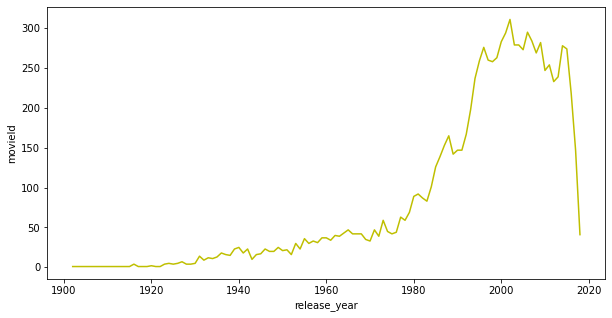

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,5)
dftmp = movies_df[['movieId', 'release_year']].groupby('release_year')
sns.lineplot(x = dftmp.release_year.first(), y = dftmp.movieId.nunique(),markers='o',color='y')

Most Movies in our dataset have been released quite recently

In [16]:
count = {}
for i in genre_columns:
    count[i] = movies_df[i].sum()
count

{'Romance': 1596,
 'Comedy': 3756,
 'Animation': 611,
 'Mystery': 573,
 'Children': 664,
 'Musical': 334,
 'Crime': 1199,
 'Action': 1827,
 'Horror': 978,
 'War': 382,
 'Western': 167,
 'Adventure': 1263,
 'Film-Noir': 87,
 'None': 25,
 'Drama': 4359,
 'Fantasy': 779,
 'Sci-Fi': 978,
 'Thriller': 1892,
 'Documentary': 440}

In [17]:
genre_count =  pd.DataFrame({'genre':count.keys(),'count':count.values()})
genre_count

,genre,count
0,Romance,1596
1,Comedy,3756
2,Animation,611
3,Mystery,573
4,Children,664
5,Musical,334
6,Crime,1199
7,Action,1827
8,Horror,978
9,War,382


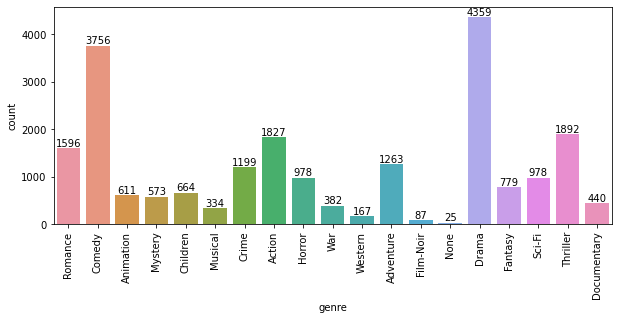

In [18]:
plt.rcParams["figure.figsize"] = (10,4)
plt.xticks(rotation=90)
ax = sns.barplot(x = 'genre',y = 'count',data = genre_count)
t  = ax.bar_label(ax.containers[0])

This graph offers count of every genre for the movies. Most movies in dataset is Drama and Comedy.

Next we are going to work on ratings csv file, it has the ratings for each movie a given user has watched. Movie and Users are identified by special identifier for the respective columns

In [12]:
ratings_df = pd.read_csv('C://Users//spssh//Desktop//Recommender//movielens//ratings.csv')
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [14]:
ratings_df.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

Ratings range from 0.5 - 5

Timestamp column needs to be preprocessed to extract datetime components. Right now its the number of seconds from 1st Jan 1970.

In [15]:
from datetime import datetime
def unix_to_datetime(t):
    ts = int(t)

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
    return (datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))

In [16]:
ratings_df['timestamp'] = ratings_df['timestamp'].apply(unix_to_datetime)
# We preprocess Date column dividing it into 3 separate coloumns
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])
ratings_df['year'] = ratings_df['timestamp'].dt.year
ratings_df['month'] = ratings_df['timestamp'].dt.month
ratings_df['day'] = ratings_df['timestamp'].dt.day
ratings_df.drop('timestamp',axis=1,inplace=True)
# This is to convert timestamp column to meaningful columns like year and month.
# ratings_df.timestamp = pd.to_datetime(ratings_df.timestamp, infer_datetime_format=True)
# ratings_df['year'] = ratings_df.timestamp.dt.year
# ratings_df.drop('timestamp',axis=1,inplace=True)
ratings_df

,userId,movieId,rating,year,month,day
0,1,1,4.0,2000,7,30
1,1,3,4.0,2000,7,30
2,1,6,4.0,2000,7,30
3,1,47,5.0,2000,7,30
4,1,50,5.0,2000,7,30
...,...,...,...,...,...,...
100831,610,166534,4.0,2017,5,3
100832,610,168248,5.0,2017,5,3
100833,610,168250,5.0,2017,5,8
100834,610,168252,5.0,2017,5,3


Extracting basic info from ratings file

In [17]:
print('Years:', ratings_df.year.unique())
print('Months', ratings_df.month.unique())
print('#Unique users:', ratings_df.userId.nunique())
print('#Unique movies:', ratings_df.movieId.nunique())
print('Unique ratings:', ratings_df.rating.unique())
print('Average rating:', round(ratings_df.rating.mean(), 2))
print('Frequency of each rating value:')
print(ratings_df['rating'].value_counts())

Years: [2000 2015 2011 2001 1999 1996 2005 2006 2007 2003 2016 1998 2009 2017
 2013 2012 2018 2014 2010 1997 2004 2002 2008]
Months [ 7  8 10  5  4 12 11  1  3  9  2  6]
#Unique users: 610
#Unique movies: 9724
Unique ratings: [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]
Average rating: 3.5
Frequency of each rating value:
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


In [18]:
ratings_df['rating'] = ratings_df['rating'].astype('int')

In [19]:
ratings_df['rating'].value_counts()

4    35369
3    33183
5    13211
2    13101
1     4602
0     1370
Name: rating, dtype: int64

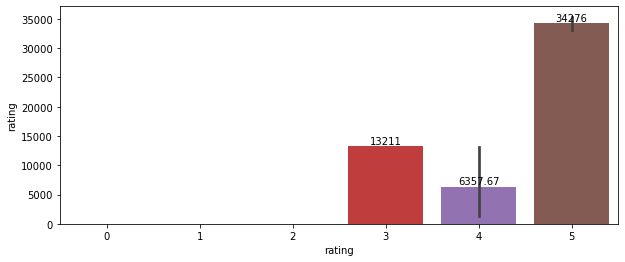

In [27]:
plt.rcParams["figure.figsize"] = (10,4)
ax = sns.barplot(x = 'rating',y = ratings_df['rating'].value_counts(),data = ratings_df,)
t  = ax.bar_label(ax.containers[0])

The graph shows most users rated 5.

Lets see number of ratings in each year

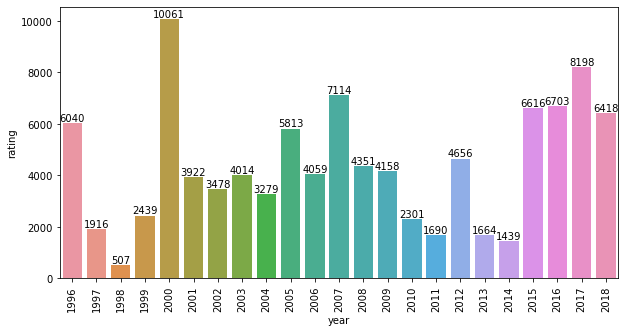

In [28]:
df_yr_rat = ratings_df[['year', 'rating']].groupby(['year']).count().reset_index()
plt.rcParams["figure.figsize"] = (10,5)
plt.xticks(rotation=90)
ax = sns.barplot(x='year', y='rating', data = df_yr_rat)
t  = ax.bar_label(ax.containers[0])

Most movies were rated in 2000, no other year even reaches 75% of 2000 ratings. 

Now have a look at the average monthly distribution of rating.



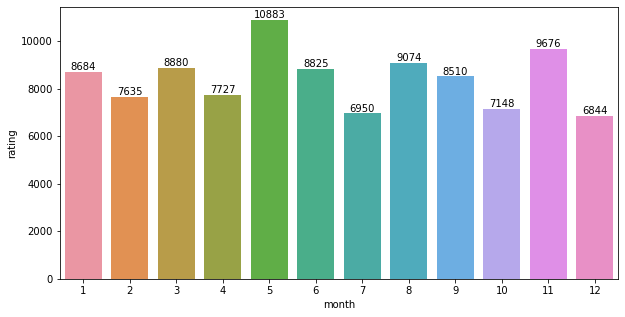

In [29]:
df_temp = ratings_df[['month', 'rating']].groupby(['month']).count().reset_index()
# df_temp['rating'] = df_temp['rating'] / 4
plt.rcParams["figure.figsize"] = (10,5)
ax = sns.barplot(x='month', y='rating', data = df_temp)
t  = ax.bar_label(ax.containers[0])

Here is monthwise count of ratings, viewership spikes in months of May, November, August and March.

Most Highly rated Movies - 

In [30]:
agg_movie =  ratings_df.groupby('movieId',as_index=False).agg({'rating':'mean'}).sort_values('rating',ascending=False,ignore_index = True)
movies_df.loc[movies_df.movieId.isin(agg_movie[agg_movie.rating == 5.0]['movieId'])]

,movieId,title,release_year,None,Film-Noir,Romance,Horror,Sci-Fi,Adventure,Action,...,Fantasy,Documentary,Crime,War,Thriller,Animation,Children,Mystery,Musical,Drama
48,53,Lamerica,1994.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
87,99,Heidi Fleiss: Hollywood Madam,1995.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
121,148,"Awfully Big Adventure, An",1995.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
405,467,Live Nude Girls,1995.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
432,495,In the Realm of the Senses (Ai no corrida),1976.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588,175431,Bobik Visiting Barbos,1977.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9633,179133,Loving Vincent,2017.0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
9634,179135,Blue Planet II,2017.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9688,184245,De platte jungle,1978.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [20]:
tags_df = pd.read_csv('C://Users//spssh//Desktop//Recommender//movielens//tags.csv')
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [33]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [39]:
#tags_df.drop('timestamp',axis=1,inplace=True)

In [21]:
tags_df['tag'] = tags_df.tag.str.lower()

In [22]:
import re
for i,j in tags_df.iterrows():
    tag = j.tag
    tag_correct = re.sub(r' \([^)]*\)','',tag)
    if 'based' or '-' in tag_correct:
        tags_df.loc[i,'tag'] = tag_correct
        continue
    if re.findall(r'\b\w{2}\b',tag_correct) or re.findall(r'\b\w{1}\b',tag_correct):
        tags_df.loc[i,'tag'] = np.NaN
    elif tag == tag_correct:
        continue
    else:
        tag_df.loc[i,'tag'] = tag_correct
        pass

tags_df = tags_df.dropna()     

In [23]:
tags_df.tail(10)

,userId,movieId,tag,timestamp
3673,606,1357,music,1176765393
3674,606,1948,british,1177512649
3675,606,3578,romans,1173212944
3676,606,5694,70mm,1175638092
3677,606,6107,world war ii,1178473747
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978
3682,610,168248,heroic bloodshed,1493844270


## Preprocessing Done

# Phase 2 - Recommender System Models

Merge the movies_df and ratings_df on movieId

In [24]:
merged_dataset = pd.merge(ratings_df, movies_df, how='inner', on='movieId')
merged_dataset

,userId,movieId,rating,year,month,day,title,release_year,Fantasy,Musical,...,Mystery,Thriller,None,Children,Drama,Film-Noir,Sci-Fi,Romance,Western,Documentary
0,1,1,4,2000,7,30,Toy Story,1995.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,5,1,4,1996,11,8,Toy Story,1995.0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,7,1,4,2005,1,25,Toy Story,1995.0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,15,1,2,2017,11,13,Toy Story,1995.0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,4,2011,5,18,Toy Story,1995.0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100813,610,160341,2,2016,11,19,Bloodmoon,1997.0,0,0,...,0,1,0,0,0,0,0,0,0,0
100814,610,160527,4,2016,11,19,Sympathy for the Underdog,1971.0,0,0,...,0,0,0,0,1,0,0,0,0,0
100815,610,160836,3,2017,5,3,Hazard,2005.0,0,0,...,0,1,0,0,1,0,0,0,0,0
100816,610,163937,3,2017,5,3,Blair Witch,2016.0,0,0,...,0,1,0,0,0,0,0,0,0,0


To make sure there's no redundancies i.e. no user has rated the same movie more than once.

In [25]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})
# merged_dataset['title']
refined_dataset

,userId,title,rating
0,1,"13th Warrior, The",4.0
1,1,20 Dates,4.0
2,1,"Abyss, The",4.0
3,1,"Adventures of Robin Hood, The",5.0
4,1,Alice in Wonderland,5.0
...,...,...,...
100446,610,[REC],4.0
100447,610,[REC]²,3.0
100448,610,[REC]³ 3 Génesis,3.0
100449,610,xXx,2.0


We notice the number of rows have reduced thus the merged table had few redundancies that have been cleared

Now we will start making our models, to help recommend movies to users.

## First Method: UserBased

In [26]:
# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(index='userId',columns='title',values='rating').fillna(0)
user_to_movie_df.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We store the pivot as scipy sparse table for efficient storage and for fast operations. Since its passed in KNN model, it needs to able to be processed fast.

In [27]:
# transform matrix to scipy sparse matrix
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<610x9433 sparse matrix of type '<class 'numpy.float64'>'
	with 99096 stored elements in Compressed Sparse Row format>

Use the Nearest Neighbours Algorithm from scikit learn on the pivot sparse table

In [28]:
knn_model_user = NearestNeighbors(metric='cosine', algorithm='auto')
knn_model_user.fit(user_to_movie_sparse_df)

NearestNeighbors(metric='cosine')

The following function finds the most similar users to the user with a given userId

In [29]:
import numpy as np
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

    knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
    distances, indices = knn_model_user.kneighbors(knn_input, n_neighbors=n+1)
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    return indices.flatten()[1:] + 1, distances.flatten()[1:]

Here's an example with UserId = 608

In [30]:
from pprint import pprint
user_id = 608
print(" Few of movies seen by the User:")
pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title'])[:10])
similar_users, distances = get_similar_users(user_id,5)

 Few of movies seen by the User:
['10 Items or Less',
 '187 (One Eight Seven)',
 '1984 (Nineteen Eighty-Four)',
 '2001: A Space Odyssey',
 '21 Grams',
 '25th Hour',
 '28 Days',
 '28 Days Later',
 '300',
 '48 Hrs.']
Top 5 users who are very much similar to the User- 608 are: 
 
1 . User: 480 separated by distance of 0.48748589042972557
2 . User: 274 separated by distance of 0.4932701375347892
3 . User: 425 separated by distance of 0.4989876207756804
4 . User: 438 separated by distance of 0.5082742144098971
5 . User: 64 separated by distance of 0.5149647568902046


Recommendation would be more effective if we define weights to ratings by each similar user based on the thier distance from the input user. Defining these weights would give us the accurate recommendations by eliminating the chance of decision manipulation by the users who are relatively very far from the input user. We'll have to make some modifications to the above model.

In [39]:
similar_users, distances

(array([480, 274, 425, 438,  64], dtype=int64),
 array([0.48748589, 0.49327014, 0.49898762, 0.50827421, 0.51496476]))

Setting the weights for given similar user list

In [40]:
weightage_list = distances/np.sum(distances)
weightage_list

array([0.194762  , 0.19707294, 0.19935721, 0.20306742, 0.20574044])

This matrix stores the user ratings of similar users on the movies

In [41]:
similar_users_ratings = user_to_movie_df.values[similar_users]
similar_users_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
movies_list = user_to_movie_df.columns
movies_list

Index([''71', ''Hellboy': The Seeds of Creation', ''Round Midnight',
       ''Salem's Lot', ''Til There Was You', ''Tis the Season for Love',
       ''burbs, The', ''night Mother', '(500) Days of Summer',
       '*batteries not included',
       ...
       'Zulu', '[REC]', '[REC]²', '[REC]³ 3 Génesis',
       'anohana: The Flower We Saw That Day - The Movie', 'eXistenZ', 'xXx',
       'xXx: State of the Union', '¡Three Amigos!',
       'À nous la liberté (Freedom for Us)'],
      dtype='object', name='title', length=9433)

In [43]:
print("Weightage list shape:", len(weightage_list))
print("similar_users_ratings shape:", similar_users_ratings.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
similar_users_ratings shape: (5, 9433)
Number of movies: 9433


We use the numpy concept of broadcasting vectors to get compatible matrix shapes to allow us to multiple weights to the ratings properly.

In [44]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 9433)

Observe  Shape is equal to Similar movie ratings by user. Now we'll apply the distance weights on ratings of similar users. We aggregate the movie ratings of the similar users and picking the top 10 or 15 movies to recommend to our current user.

In [45]:
new_rating_matrix = weightage_list*similar_users_ratings
mean_rating = new_rating_matrix.sum(axis =0)
mean_rating

array([0., 0., 0., ..., 0., 0., 0.])

Each value is the mean rating to the movie given by similar users.

This following function sorts the mean rating of each movie as given by similar users to output an list of indices of the movie titles that will be recommended. 

In [57]:
from pprint import pprint
def recommend_movies(n):
    n = min(len(mean_rating),n)
    pprint(list(movies_list[np.argsort(mean_rating)[::-1][:n]]))

In [58]:
print("Movies recommended based on similar users to 608 are: ")
recommend_movies(10)

Movies recommended based on similar users to 608 are: 
['Shawshank Redemption, The',
 "Schindler's List",
 'Lord of the Rings: The Fellowship of the Ring, The',
 'Forrest Gump',
 'Lord of the Rings: The Return of the King, The',
 'Memento',
 'Matrix, The',
 'Lord of the Rings: The Two Towers, The',
 'Princess Bride, The',
 'Erin Brockovich']


The above functions and operations showed the operations we need to implement for one user. Now we encapsulate all this into one single function that inputs userId, number of users to consider and number of movies to recommend.

In [53]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies):
    # This system recommends the top movies watched by the similar users to user with Id -- user_id
    # And based on the number of n_similar_users and n_movies to recommend we output the recommendations.
    print("Movie seen by the User:")
    pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title']))
    print("")
    def get_similar_users(user, n = 5):
        knn_input = np.asarray([user_to_movie_df.values[user-1]])
        # Similar to function we made above
        
    
        distances, indices = knn_model_user.kneighbors(knn_input, n_neighbors=n+1)
    
        print("Top",n,"users who are very much similar to the User-",user, "are: ")
        print(" ")

        for i in range(1,len(distances[0])):
            print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
            print("")
        return indices.flatten()[1:] + 1, distances.flatten()[1:]
    
    def recommend_movies(n):
        #Outputs the recommendations
        n = min(len(mean_rating_list),n)
        print(np.argsort(mean_rating_list)[::-1][:n])
        pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))
        
    similar_users, distances = get_similar_users(user_id,n_similar_users)
    weightage_list = distances/np.sum(distances)
    similar_users_ratings = user_to_movie_df.values[similar_users]
    movies_list = user_to_movie_df.columns
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list*similar_users_ratings
    mean_rating_list = new_rating_matrix.sum(axis =0)
    print("")
    print("Movies recommended based on similar users are: ")
    print("")
    recommend_movies(n_movies)


In [54]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)

Enter user id
610
number of similar users to be considered
5
Enter number of movies to be recommended:
5
Movie seen by the User:
["'71",
 '(500) Days of Summer',
 '10 Cloverfield Lane',
 '127 Hours',
 '13 Assassins (Jûsan-nin no shikaku)',
 '13 Hours',
 '13 Sins',
 '1408',
 '16 Blocks',
 '2 Fast 2 Furious (Fast and the Furious 2, The)',
 '2001 Maniacs',
 '2001: A Space Odyssey',
 '2012',
 '22 Jump Street',
 '25th Hour',
 '28 Days Later',
 '28 Weeks Later',
 '30 Days of Night',
 '300',
 '3000 Miles to Graceland',
 '31',
 '3:10 to Yuma',
 '40-Year-Old Virgin, The',
 '48 Hrs.',
 '50 First Dates',
 '50/50',
 '6th Day, The',
 '9',
 'A Million Ways to Die in the West',
 'A-Team, The',
 'A.I. Artificial Intelligence',
 'ABCs of Death, The',
 'AVP: Alien vs. Predator',
 'AVPR: Aliens vs. Predator - Requiem',
 'Abandoned, The',
 'About Time',
 'About a Boy',
 'Abraham Lincoln: Vampire Hunter',
 'Absentia',
 'Abyss, The',
 'Accidental Spy, The (Dak miu mai shing)',
 'Ace Ventura: Pet Detective',

## Second Method: Item Based

Now we make a model that recommends movie names based on movie name inputted. Basically outputting most similar movies to a given movie.

New pivot table is basically transpose of previous one. 

In [232]:
import numpy as np

ratings_pivot = refined_dataset.pivot(index='title',columns='userId',values='rating').fillna(0)

ratings_pivot

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
xXx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0
xXx: State of the Union,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [244]:
ratings_pivot.shape


(9433, 610)

Representing a sparse matrix as 2D array leads to wastage of lots of memory as zeroes in the matrix are mostly useless in the representation. So, instead of storing zeroes with non-zero elements, we only store non-zero elements. This means storing non-zero elements with triples- (Row, Column, value).

SciPy gives tools for creating sparse matrices using multiple data structures, as well as tools for converting a dense matrix to a sparse matrix. The function csr_matrix() is used to create a sparse matrix of compressed sparse row format.

The classes in sklearn.neighbors can handle either NumPy arrays or scipy.sparse matrices as input. We will use sparse matrix as input to the model for efficient memory storage and saving computing time.

In [233]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

movie_to_user_sparse_df = csr_matrix(ratings_pivot.values)
movie_to_user_sparse_df

<9433x610 sparse matrix of type '<class 'numpy.float64'>'
	with 99096 stored elements in Compressed Sparse Row format>

In [188]:
knn_model = NearestNeighbors(algorithm='brute')
knn_model.fit(movie_to_user_sparse_df)

NearestNeighbors(algorithm='brute')

In [189]:
movies_list = list(ratings_pivot.index)
movie_dict = {movie : index for index, movie in enumerate(movies_list)}

In [215]:
## function to find top n similar users of the given input user 
def get_similar_movies(movie, n = 10):
    index = movie_dict[movie]
    knn_input = np.asarray([ratings_pivot.values[index]])
    n = min(len(movies_list)-1,n)
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
    print(" ")
    recommended_list =[]
    for i in range(1,len(distances[0])):
        recommended_list.append(movies_list[indices[0][i]])
    return recommended_list

Following output uses a modified version of above function that prints movie names instead of storing in a list, this latter version's use is explained below.

In [216]:
from pprint import pprint
movie_name = 'Godfather, The'

get_similar_movies(movie_name,15)

Top 15 movies which are very much similar to the Movie- Godfather, The are: 
 


['Godfather: Part II, The',
 'Goodfellas',
 "One Flew Over the Cuckoo's Nest",
 'Reservoir Dogs',
 'Apocalypse Now',
 'Taxi Driver',
 'Scarface',
 'Psycho',
 'Alien',
 'Fargo',
 'Casablanca',
 "Ferris Bueller's Day Off",
 'Rear Window',
 'Full Metal Jacket',
 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il)']

#### Now, for fast querying and to make sure we dont train model everytime we ask for recommendation. We'll apply the concept of pre-structuring learnt in DAA in 4th Sem of Data Science Course, i.e. preprocessing and storing useful information for fast retrieval.

In [ ]:
# recommendations = {}
# for i in movies_list:
#     recommendations[i] = get_similar_movies(i)

In [ ]:
# recommendations

In [ ]:
# import sys

# print("The size of the dictionary is {} kilobytes".format(sys.getsizeof(recommendations)/1024))

We will pickle this dictionary.

In [ ]:
# import pickle
# with open('prestructuring-results.pickle', 'wb') as handle:
#     pickle.dump(recommendations, handle, protocol=pickle.HIGHEST_PROTOCOL)

At this stage in the submitted Phase 2 work, I have made use of 2nd approach in the API, that is recommending movies based only on movie name.

In the next submission I hope to combine the 1st and 2nd Methods or develop a better model. Also, I hope to solve the cold start problem which hasnt been dealt with yet. The solution of pickling is an efficient solution assuming no new items are added, since that would call for re-training. I also aim to add that functionality, since pickling offers a very simple solution, though it speeds up the API calls by a huge margin(Since otherwise, we'll have to train the model everytime a request is sent).

## 3rd Method: Combining User Similarity Model and Item Similarity Model.

##### Now we will combine the user based and item based models to give our results. The basic gist of this method is that it'll take input the userId as input and movie name. Based on these inputs, the model first finds the similar users to the given userID, collects the movies he/she has watched into a dataframe. Now, a knn model will be trained based on the distances from the given movie name to find most similar movies to them one requested to the user from the movies that similar users have watched.

### Nearest Neighbours Algorithm will be used extensively here

####  Brute Force
Brute-force computation of distances between all pairs of points in the dataset: For N samples in  dimensions D, this approach scales as O(DN^2). Very competitive for small data samples. However, as the number of samples N grows, this approach becomes infeasible.

#### KD Tree
To address inefficiencies of Brute-Force methods, tree-based data structures used. In general, these models try to reduce number of distance calculations by efficiently encoding distance information for sample. Basic idea is if A is distant from B and B is close to C, then we know C is also far from A without any calculations. Computational Cost reduces to O(DNlog(N)) or better.
Construction is fast, once constructed nearest neighbour computed in O(log(N)) computations. Very fast for low-dimensional D<20 neighbour searches. It becomes inefficient as D increases.

#### Ball Tree
To address KD Trees inefficiencies and mantain the good points of it. Tree construction is more costly however it results into a very efficient one even in high dimensions. 


##### Since, NearestNeighbour has default parameter 'auto' for algorithm it chooses, so it may be choosing 'ball-tree' only for the high sample and high dimensional data that is our ratings_pivot but we'll make that choice explicitly now.

In [235]:
knn_model = NearestNeighbors(algorithm='ball_tree')
knn_model.fit(ratings_pivot.values)

NearestNeighbors(algorithm='ball_tree')

In [240]:
from pprint import pprint

def recommender_system_3(user_id, movie_name,n_similar_users, n_movies):
    # This system recommends the top movies watched by the similar users to user with Id -- user_id
    # And based on the number of n_similar_users and n_movies to recommend we output the recommendations.
    
    #List to store movies seen by user
    movies_seen = list(refined_dataset[refined_dataset['userId'] == user_id]['title'])
    print(movies_seen)
    def get_similar_users(user, n = 5):
        knn_input = np.asarray([user_to_movie_df.values[user-1]])
        # Similar to function we made above
        distances, indices = knn_model_user.kneighbors(knn_input, n_neighbors=n+1)
        print("Top",n,"users who are very much similar to the User-",user, "are: ")
        print(" ")
        for i in range(1,len(distances[0])):
            print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
            print("")
        return indices.flatten()[1:] + 1, distances.flatten()[1:]
    
    
    def recommend_userbased():
         #Outputs indices of movies as rated by similar users
        similar_users_movies_indices = np.argsort(mean_rating_list)[::-1]
        similar_user_movie_names = movies_df[movies_df['movieId'].isin(similar_users_movies_indices)]['title'].values
        return similar_user_movie_names


    def get_similar_movies(movie):
        # Outputs the movies similar to the given movie name.
        index = movie_dict[movie]
        knn_input = np.asarray([ratings_pivot.values[index]])
        distances, indices = knn_model.kneighbors(knn_input,20)
        recommended_list =[]
        for i in range(1,len(distances[0])):
            recommended_list.append(movies_list[indices[0][i]])
        return recommended_list

        
        
    similar_users, distances = get_similar_users(user_id,n_similar_users)
    weightage_list = distances/np.sum(distances)
    similar_users_ratings = user_to_movie_df.values[similar_users]
    movies_list = user_to_movie_df.columns
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list*similar_users_ratings
    mean_rating_list = new_rating_matrix.sum(axis =0)
    similar_users_movies = recommend_userbased()
    # Filtering out the movies already seen by user
    filtered_similar_movies = [i for i in similar_users_movies if i not in movies_seen]
    print(filtered_similar_movies)
    recommended_list =  get_similar_movies(movie_name)
    final_list = [i for i in recommended_list if i in filtered_similar_movies]
    print(final_list)
    return final_list[:n_movies]


In [241]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
print("Enter Name of movie:")
movie_name = input()
print(recommender_system_3(user_id,movie_name,sim_users,n_movies))
# 

Enter user id
610
number of similar users to be considered
6
Enter number of movies to be recommended:
6
Enter Name of movie:
Toy Story
["'71", '(500) Days of Summer', '10 Cloverfield Lane', '127 Hours', '13 Assassins (Jûsan-nin no shikaku)', '13 Hours', '13 Sins', '1408', '16 Blocks', '2 Fast 2 Furious (Fast and the Furious 2, The)', '2001 Maniacs', '2001: A Space Odyssey', '2012', '22 Jump Street', '25th Hour', '28 Days Later', '28 Weeks Later', '30 Days of Night', '300', '3000 Miles to Graceland', '31', '3:10 to Yuma', '40-Year-Old Virgin, The', '48 Hrs.', '50 First Dates', '50/50', '6th Day, The', '9', 'A Million Ways to Die in the West', 'A-Team, The', 'A.I. Artificial Intelligence', 'ABCs of Death, The', 'AVP: Alien vs. Predator', 'AVPR: Aliens vs. Predator - Requiem', 'Abandoned, The', 'About Time', 'About a Boy', 'Abraham Lincoln: Vampire Hunter', 'Absentia', 'Abyss, The', 'Accidental Spy, The (Dak miu mai shing)', 'Ace Ventura: Pet Detective', 'Adaptation', 'Adjustment Bureau,

Now start pickling and stoering things that we will need in API.
- Refined_Dataset Dataframe
- knn_model_user
- movies_df
- knn_model
- movie_dict and movie_list

In [242]:
import pickle

with open('refined_dataset.pickle', 'wb') as handle:
    pickle.dump(refined_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('user_to_user_model.pickle', 'wb') as handle:
    pickle.dump(knn_model_user, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_to_item_model.pickle', 'wb') as handle:
    pickle.dump(knn_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('movie_df.pickle', 'wb') as handle:
    pickle.dump(movies_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('movies_list.pickle', 'wb') as handle:
    pickle.dump(movies_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('movies_dict.pickle', 'wb') as handle:
    pickle.dump(movie_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)